# Домашнее задание №7. Обработка видео
Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

In [1]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
!pip install scikit-video==1.1.11
import skvideo.io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 18.7 MB/s 


### Загрузка и подготовка данных

In [9]:
#скачиваем архивы с датасетами
!wget http://www.csc.kth.se/cvap/actions/walking.zip
!wget http://www.csc.kth.se/cvap/actions/jogging.zip
!wget http://www.csc.kth.se/cvap/actions/running.zip
!wget http://www.csc.kth.se/cvap/actions/boxing.zip
!wget http://www.csc.kth.se/cvap/actions/handwaving.zip
!wget http://www.csc.kth.se/cvap/actions/handclapping.zip

--2022-08-24 17:19:16--  http://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2022-08-24 17:19:17--  https://www.csc.kth.se/cvap/actions/walking.zip
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.28.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242442411 (231M) [application/zip]
Saving to: ‘walking.zip’

walking.zip         100%[===================>] 231.21M  4.88MB/s    in 46s     

2022-08-24 17:20:03 (4.99 MB/s) - ‘walking.zip’ saved [242442411/242442411]

URL transformed to HTTPS due to an HSTS policy
--2022-08-24 17:20:03--  https://www.csc.kth.se/cvap/actions/jogging.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c2

In [10]:
#распаковываем архивы
!unzip walking.zip -d walking > /dev/null
!unzip jogging.zip -d jogging > /dev/null
!unzip running.zip -d running > /dev/null
!unzip boxing.zip -d boxing > /dev/null
!unzip handwaving.zip -d handwaving > /dev/null
!unzip handclapping.zip -d handclapping > /dev/null

In [11]:
#удаляем архивы (чтобы освободить место на диске)
!rm walking.zip
!rm jogging.zip
!rm running.zip
!rm boxing.zip
!rm handwaving.zip
!rm handclapping.zip

In [12]:
#список классов
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

In [13]:
#составляем список (путь к видео, класс)

# Для обучения будем использовать весь набор данных, а не часть
dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
      dataset.append((fpath, cls)) #(путь, класс)
print(f'Количество объектов: {len(dataset)}')

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping
Количество объектов: 599


videodata shape: (868, 120, 160, 3)
motion shape: (867, 120, 160, 1)


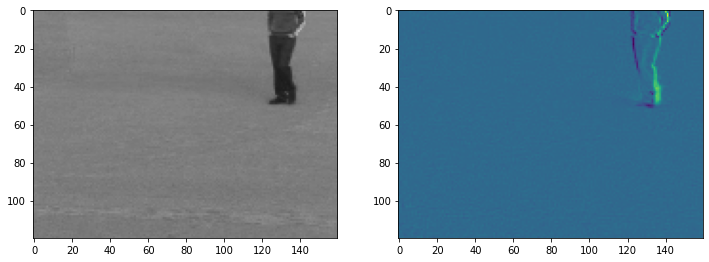

In [14]:
# Визуализация 
# Визуализируем 50-й кадр из видео с индексом 3

plt.figure(figsize = (12, 6))
plt.subplot(1,2,1)
videodata = skvideo.io.vread(dataset[3][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

plt.subplot(1,2,2)
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

plt.show()

In [24]:
#создание тренировочного и тестового датасетов

random.shuffle(dataset)

# Раздедим на train и test
TEST_NUM_OBJECTS = len(dataset)//6

NUM_FRAMES = 200
NUM_EPOCHS = 5
BATCH_SIZE = 2

random.shuffle(dataset)

def motion_prepare(obj, NUM_FRAMES = 200):
  videodata = skvideo.io.vread(obj.numpy()[0].decode('UTF-8'), num_frames=NUM_FRAMES)
  videodata = videodata.astype(np.float32) / 255.
  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
  return motion, classes.index(obj.numpy()[1].decode('UTF-8'))

def set_shapes(motion, cl_idx):
      #TensorFlow после использования tf.py_function не может установить выходные размеры
      #Поэтому установим их вручную
    motion.set_shape((199, 120, 160, 1))
    cl_idx.set_shape([])
    return motion, cl_idx

#создание датасетов
train_ds = tf.data.Dataset.from_tensor_slices(dataset[:-TEST_NUM_OBJECTS])
train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(lambda video_class: tf.py_function(func=motion_prepare,
                                                            inp=[video_class], 
                                                           Tout=[tf.float32, tf.uint8]))
train_ds = train_ds.map(lambda x, y: set_shapes(x, y))
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тренировочного датасета: {len(train_ds)}')

test_ds = tf.data.Dataset.from_tensor_slices(dataset[-TEST_NUM_OBJECTS:])
test_ds = test_ds.map(lambda video_class: tf.py_function(func=motion_prepare,
                                                          inp=[video_class], 
                                                         Tout=[tf.float32, tf.uint8]))
test_ds = test_ds.map(lambda x, y: set_shapes(x, y))
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)
print(f'Длина тестового датасета: {len(test_ds)}')

Длина тренировочного датасета: 250
Длина тестового датасета: 49


### Построение и обучение модели

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None)
])

In [32]:
LEARNING_RATE = 0.001

# Компиляция
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics = ['accuracy'])

In [33]:
#обучение модели

NUM_EPOCHS = 10

history = model.fit(
                     train_ds,
                     epochs=NUM_EPOCHS,
                     validation_data=test_ds,
                    )

Epoch 1/10
250/250 [==============================] - 231s 921ms/step - loss: 1.4652 - accuracy: 0.3160 - val_loss: 0.9123 - val_accuracy: 0.6633
Epoch 2/10
250/250 [==============================] - 232s 926ms/step - loss: 0.7008 - accuracy: 0.7620 - val_loss: 0.7313 - val_accuracy: 0.7143
Epoch 3/10
250/250 [==============================] - 227s 908ms/step - loss: 0.4598 - accuracy: 0.8060 - val_loss: 0.3826 - val_accuracy: 0.8163
Epoch 4/10
250/250 [==============================] - 226s 902ms/step - loss: 0.4175 - accuracy: 0.8480 - val_loss: 0.3204 - val_accuracy: 0.8571
Epoch 5/10
250/250 [==============================] - 230s 920ms/step - loss: 0.3033 - accuracy: 0.8880 - val_loss: 0.3416 - val_accuracy: 0.9082
Epoch 6/10
250/250 [==============================] - 227s 908ms/step - loss: 0.3037 - accuracy: 0.8820 - val_loss: 0.2867 - val_accuracy: 0.8980
Epoch 7/10
250/250 [==============================] - 225s 898ms/step - loss: 0.1726 - accuracy: 0.9280 - val_loss: 0.3222 -

In [34]:
#оценка качества модели
model.evaluate(test_ds)

49/49 [==============================] - 36s 733ms/step - loss: 0.4003 - accuracy: 0.8776


[0.4003293514251709, 0.8775510191917419]

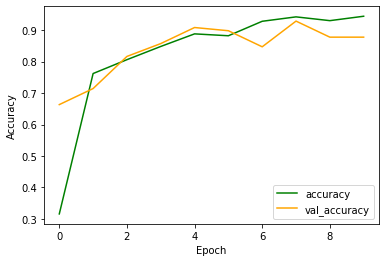

In [38]:
plt.plot(history.history['accuracy'], label='accuracy', color = 'green')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

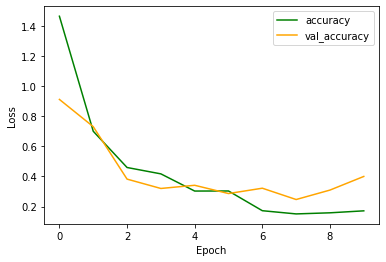

In [41]:
plt.plot(history.history['loss'], label='accuracy', color = 'green')
plt.plot(history.history['val_loss'], label = 'val_accuracy', color = 'orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0.5, 1])
plt.legend(loc='upper right')
plt.show()

### Тестирование полученной модели

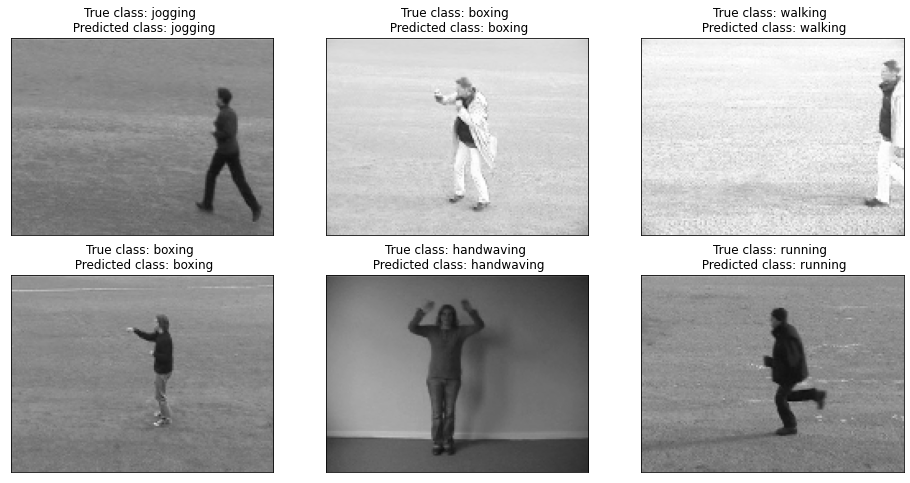

In [45]:
#тестирование модели на тестовом датасете
fpath_cls_true_list = random.sample(dataset[-TEST_NUM_OBJECTS:], 6) #список из 6 элементов
fig = plt.figure(figsize=(16, 8))
for i in range(len(fpath_cls_true_list)):
  ax = fig.add_subplot(2, 3, i+1)
  videodata = skvideo.io.vread(fpath_cls_true_list[i][0])
  videodata = videodata.astype(np.float32) / 255.
  plt.imshow(videodata[15, ...])
  
  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())
  plt.title(f'True class: {fpath_cls_true_list[i][1]} \n Predicted class: {classes[cls_pred]}')
  plt.xticks([]), plt.yticks([])
plt.show()

Модель вполне успешно выполняет классификацию.